<a href="https://colab.research.google.com/github/russmendez/DS_notebooks/blob/master/Netflix_Unsupervised_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Netflix wants to identify similar movies based on movie characteristics.
   

#Loading the data

According to the description from kaggel:

This dataset consists of tv shows and movies available on Netflix as of 2019. The dataset is collected from Flixable which is a third-party Netflix search engine.

The goal of this project is to identify similar movies and shows based on their characteristics.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import umap
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from sklearn import datasets, metrics

from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split 

from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.mixture import GaussianMixture
from sklearn.cluster import DBSCAN

!pip install rake_nltk
#The install code needs to be run everytime. Why is that?
from rake_nltk import Rake

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
#!unzip '/content/drive/My Drive/archive (3).zip' -d '/content/drive/My Drive/'
netflix_df = pd.read_csv('drive/My Drive/netflix_titles.csv')

Mounted at /content/drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
#!unzip '/content/drive/My Drive/archive (4).zip' -d '/content/drive/My Drive/'
master_movie_df = pd.read_csv('drive/My Drive/MoviesOnStreamingPlatforms_updated.csv')

In [ ]:
netflix_df.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,81145628,Movie,Norm of the North: King Sized Adventure,"Richard Finn, Tim Maltby","Alan Marriott, Andrew Toth, Brian Dobson, Cole...","United States, India, South Korea, China","September 9, 2019",2019,TV-PG,90 min,"Children & Family Movies, Comedies",Before planning an awesome wedding for his gra...
1,80117401,Movie,Jandino: Whatever it Takes,NaN,Jandino Asporaat,United Kingdom,"September 9, 2016",2016,TV-MA,94 min,Stand-Up Comedy,Jandino Asporaat riffs on the challenges of ra...
2,70234439,TV Show,Transformers Prime,NaN,"Peter Cullen, Sumalee Montano, Frank Welker, J...",United States,"September 8, 2018",2013,TV-Y7-FV,1 Season,Kids' TV,"With the help of three human allies, the Autob..."
3,80058654,TV Show,Transformers: Robots in Disguise,NaN,"Will Friedle, Darren Criss, Constance Zimmer, ...",United States,"September 8, 2018",2016,TV-Y7,1 Season,Kids' TV,When a prison ship crash unleashes hundreds of...
4,80125979,Movie,#realityhigh,Fernando Lebrija,"Nesta Cooper, Kate Walsh, John Michael Higgins...",United States,"September 8, 2017",2017,TV-14,99 min,Comedies,When nerdy high schooler Dani finally attracts...


In [ ]:
netflix_df['title']

0           Norm of the North: King Sized Adventure
1                        Jandino: Whatever it Takes
2                                Transformers Prime
3                  Transformers: Robots in Disguise
4                                      #realityhigh
                           ...                     
6229                                   Red vs. Blue
6230                                          Maron
6231         Little Baby Bum: Nursery Rhyme Friends
6232    A Young Doctor's Notebook and Other Stories
6233                                        Friends
Name: title, Length: 6234, dtype: object

In [ ]:
netflix_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6234 entries, 0 to 6233
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       6234 non-null   int64 
 1   type          6234 non-null   object
 2   title         6234 non-null   object
 3   director      4265 non-null   object
 4   cast          5664 non-null   object
 5   country       5758 non-null   object
 6   date_added    6223 non-null   object
 7   release_year  6234 non-null   int64 
 8   rating        6224 non-null   object
 9   duration      6234 non-null   object
 10  listed_in     6234 non-null   object
 11  description   6234 non-null   object
dtypes: int64(2), object(10)
memory usage: 584.6+ KB


In [ ]:
netflix_df.isna().sum()/netflix_df.count()*100

show_id          0.000000
type             0.000000
title            0.000000
director        46.166471
cast            10.063559
country          8.266759
date_added       0.176764
release_year     0.000000
rating           0.160668
duration         0.000000
listed_in        0.000000
description      0.000000
dtype: float64

There are 12 columns to work with in this dataset. The director column is 46% empty and poses the greatest limitation in terms of NaN values. Cast and country are 10% and 8% NaN, respectively. However, for our purposes, this may not be significant.

#EDA/Data Cleaning/Feature Engineering



Distribution of type

The data is about 2/3 movies and 1/3 TV shows. 

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


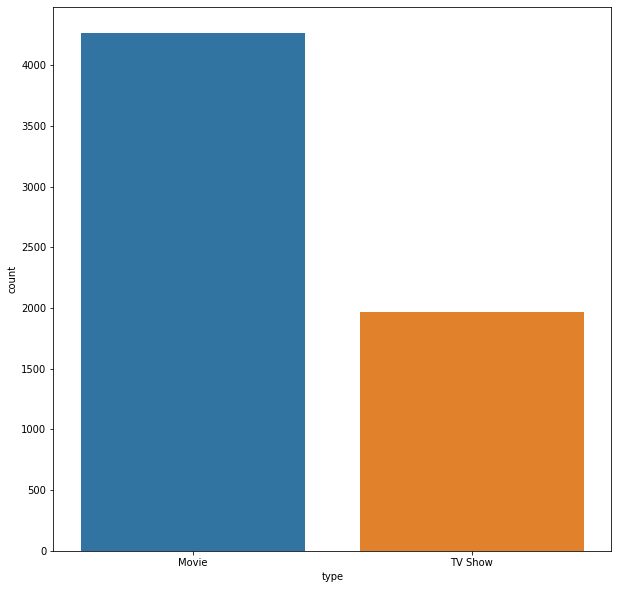

In [ ]:
figure = plt.figure(figsize=(10,10))
sns.countplot(netflix_df['type'])

Distribution of rating.

The largest group of ratings is TV-MA. An interesting point to note is that only 1017 'Movies' are rated with the movie style rating system: G, PG, PG-13, R, and NC-17. This means the remaining 'Movies' must be rated with the TV rating system.

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]),
 <a list of 14 Text major ticklabel objects>)

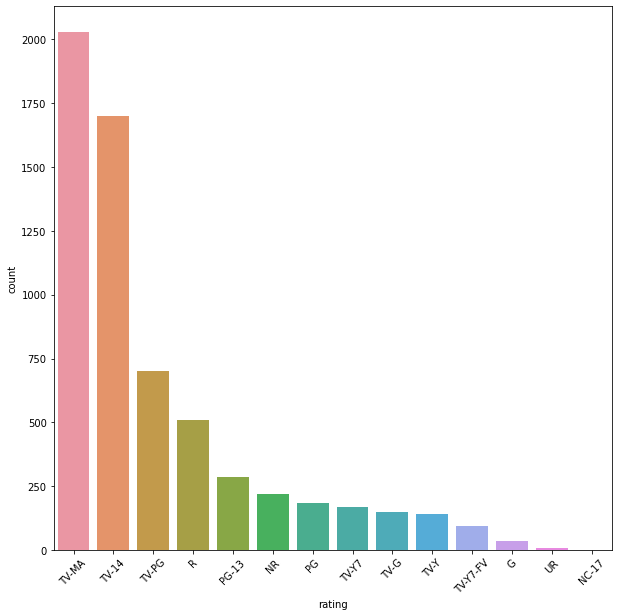

In [ ]:
figure = plt.figure(figsize=(10,10))
sns.countplot(x = netflix_df['rating'].dropna(), order=netflix_df['rating'].dropna().value_counts().index)
plt.xticks(rotation=45)

In [ ]:
netflix_df['rating'].dropna().unique()

array(['TV-PG', 'TV-MA', 'TV-Y7-FV', 'TV-Y7', 'TV-14', 'R', 'TV-Y', 'NR',
       'PG-13', 'TV-G', 'PG', 'G', 'UR', 'NC-17'], dtype=object)

In [ ]:
len(netflix_df[netflix_df['rating'].isin(['NC-17','R', 'PG-13', 'PG', 'G'])])

1017

#Recommender 1 - netflix_df

### Content Based Filtering 

In this recommender system I use cast, director, listen_in(genre), description, and rating. More of the columns could be used with some minor changes to the code. I join all these features into one string per movie title and then Rake() them to get the important words. I use count vectorization and cosine similarity on the Raked bag of words to get vectorized data. That data is then run through a funtion, recommend_movie(), which returns a list of 10 movies that most closely resemble the imput based on the characteristics used in the program. 

In [ ]:
# Features: cast, director, listen_in(genre), description
# Target: title
df = netflix_df.copy()
df['director'] = df['director'].fillna('')
#df['director'] = df['director'].apply(lambda x: x.repalce(',', ' '))
df['cast'] = df['cast'].fillna('')
#df['cast'] = df['cast'].apply(lambda x: x.repalce(',', ' '))
df['rating'] = df['rating'].fillna('')
#df['rating'] = df['rating'].apply(lambda x: x.repalce('-', ''))
#df['listed_in'] = df['listed_in'].apply(lambda x: x.repalce('-', ''))
df = df.astype(str)

#everything needs to be lowercase to avoid duplications

df['director'] = df['director'].str.lower()
df['cast'] = df['cast'].str.lower()
df['rating'] = df['rating'].str.lower()
df['type'] = df['type'].str.lower()
df['listed_in'] = df['listed_in'].str.lower()

#merge the names of cast members and directors into 1 terms. This will avoid situations where the wrong name is related in the algorithm.
#i.e. if several actors share the same first or last name. 

df['cast'] = df['cast'].apply(lambda x: x.replace(' ',''))
df['director'] = df['director'].apply(lambda x: x.replace(' ',''))

df['new_col'] = df[['director', 'cast', 'listed_in', 'rating', 'description']].agg(' '.join, axis = 1)

#------
df['key_words'] = ""
for index, row in df.iterrows():
    plot = row['new_col']

    # instantiating Rake, by default it uses english stopwords from NLTK
    # and discards all puntuation characters as well
    r = Rake()

    # extracting the words by passing the text
    r.extract_keywords_from_text(plot)

    # getting the dictionary whith key words as keys and their scores as values
    key_words_dict_scores = r.get_word_degrees()

    # assigning the key words to the new column for the corresponding movie
    row['key_words'] = list(key_words_dict_scores.keys())

    # casting 'kew_words' to string
    s = row['key_words']
    listtojoin = ' '.join([str(elem) for elem in s])
    row['key_words'] = listtojoin

#df['bag_of_words'] = df[['type', 'cast', 'director', 'listed_in', 'key_words']].agg(''.join, axis=1)
netflix_bag_df = df[['title', 'key_words']]
#test_df.head()


#------
# instantiating and generating the count matrix
count = CountVectorizer()
netflix_count_matrix = count.fit_transform(netflix_bag_df['key_words'])

# generating the cosine similarity matrix
# To compute similarity between the user and item, we simply take the cosine similarity between the user vector and the item vector. 
# This gives us user-item similarity. This is useful in this case because the feature vectors are so close to the target vector.
netflix_cosine_sim = cosine_similarity(netflix_count_matrix, netflix_count_matrix)


#------
# creating a Series for the movie titles so they are associated to an ordered numerical
# list I will use in the function to match the indexes
indices = pd.Series(netflix_bag_df['title'])
#  defining the function that takes in movie title 
# as input and returns the top 10 recommended movies
def netflix_count_recommend_movie(name):
    # initializing the empty list of recommended movies
    movie=[]
     # gettin the index of the movie that matches the title
    idx = indices[indices == name].index[0]
    # creating a Series with the similarity scores in descending order
    sort_index = pd.Series(netflix_cosine_sim[idx]).sort_values(ascending = False)
    # getting the indexes of the 10 most similar movies
    top_10 = sort_index.iloc[1:11]
    # populating the list with the titles of the best 10 matching movies
    for i in top_10.index:
        movie.append(indices[i])
    return movie


#-------

tf_idf_df = df[['title', 'key_words']]


vectorizer = TfidfVectorizer()
netflix_vectors = vectorizer.fit_transform(tf_idf_df['key_words'])

netflix_tfidf_sim = cosine_similarity(netflix_vectors, netflix_vectors)
#feature_names = vectorizer.get_feature_names
#dense = vectors.todense()
#denselist = dense.tolist()
#tf_df = pd.DataFrame(denselist, columns=feature_names)
#tf_df
indices = pd.Series(tf_idf_df['title'])
#  defining the function that takes in movie title 
# as input and returns the top 10 recommended movies
def netflix_tfidf_recommend_movie(name):
    # initializing the empty list of recommended movies
    movie=[]
     # gettin the index of the movie that matches the title
    idx = indices[indices == name].index[0]
    # creating a Series with the similarity scores in descending order
    sort_index = pd.Series(netflix_tfidf_sim[idx]).sort_values(ascending = False)
    # getting the indexes of the 10 most similar movies
    top_10 = sort_index.iloc[1:11]
    # populating the list with the titles of the best 10 matching movies
    for i in top_10.index:
        movie.append(indices[i])
    return movie

In [ ]:
netflix_bag_df.head()

,title,key_words
0,Norm of the North: King Sized Adventure,colehoward michaeldobson children grandfather ...
1,Jandino: Whatever it Takes,challenges audience sex fire jandinoasporaat s...
2,Transformers Prime,decepticons kevinmichaelrichardson y7 autobots...
3,Transformers: Robots in Disguise,decepticons stuartallan petercullen kids khary...
4,#realityhigh,longtime crush lands patrickdavis comedies tv ...


In [ ]:
netflix_cosine_sim

array([[1.        , 0.04222003, 0.03350126, ..., 0.08989331, 0.06700252,
        0.06700252],
       [0.04222003, 1.        , 0.09335201, ..., 0.        , 0.046676  ,
        0.046676  ],
       [0.03350126, 0.09335201, 1.        , ..., 0.        , 0.03703704,
        0.03703704],
       ...,
       [0.08989331, 0.        , 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.06700252, 0.046676  , 0.03703704, ..., 0.        , 1.        ,
        0.07407407],
       [0.06700252, 0.046676  , 0.03703704, ..., 0.        , 0.07407407,
        1.        ]])

In [ ]:
netflix_count_recommend_movie('Transformers Prime')

['Transformers: Robots in Disguise',
 'All Hail King Julien: Exiled',
 'Miniforce X',
 'Kipo and the Age of Wonderbeasts',
 'Kulipari: Dream Walker',
 'We Bare Bears',
 'Kulipari: An Army of Frogs',
 'Tobot',
 'Motu Patlu: King of Kings',
 'Power Rangers Ninja Steel']

In [ ]:
netflix_tfidf_recommend_movie('Transformers Prime')

['Transformers: Robots in Disguise',
 'All Hail King Julien: Exiled',
 'Kulipari: Dream Walker',
 'Kulipari: An Army of Frogs',
 'Kipo and the Age of Wonderbeasts',
 'Miniforce X',
 '3Below: Tales of Arcadia',
 'Voltron: Legendary Defender',
 'LEGO: Marvel Super Heroes: Maximum Overload',
 'Transformers: Rescue Bots']

### K-Means

K-Means does not perform well with this model. However, this should not be too concerning as the vectorized data ultimately produces tons of sparse data and it would be difficult for this model to effectively cluster them. 

In [ ]:
#Euclidean, 3 
y = netflix_bag_df['title']
X = netflix_cosine_sim

labels = KMeans(n_clusters=3, random_state=123).fit_predict(X)
print(metrics.silhouette_score(X, labels, metric='euclidean'))

0.20037846896640196


In [ ]:
y = netflix_bag_df['title']
X = netflix_tfidf_sim

labels = KMeans(n_clusters=3, random_state=123).fit_predict(X)
print(metrics.silhouette_score(X, labels, metric='euclidean'))

0.023899239580718965


In [ ]:
#Euclidean,5 
y = netflix_bag_df['title']
X = netflix_cosine_sim

labels = KMeans(n_clusters=5, random_state=123).fit_predict(X)
print(metrics.silhouette_score(X, labels, metric='euclidean'))

0.18104583182655443


In [ ]:
y = netflix_bag_df['title']
X = netflix_tfidf_sim

labels = KMeans(n_clusters=5, random_state=123).fit_predict(X)
print(metrics.silhouette_score(X, labels, metric='euclidean'))

0.026558556012244296


In [ ]:
#Cosine, 3
y = netflix_bag_df['title']
X = netflix_cosine_sim

labels = KMeans(n_clusters=3, random_state=123).fit_predict(X)
print(metrics.silhouette_score(X, labels, metric='cosine'))

0.07908668955724525


In [ ]:
y = netflix_bag_df['title']
X = netflix_tfidf_sim

labels = KMeans(n_clusters=3, random_state=123).fit_predict(X)
print(metrics.silhouette_score(X, labels, metric='cosine'))

0.03821377141953984


In [ ]:
#Cosine, 5
y = netflix_bag_df['title']
X = netflix_cosine_sim

labels = KMeans(n_clusters=5, random_state=123).fit_predict(X)
print(metrics.silhouette_score(X, labels, metric='cosine'))

0.09380629221143819


In [ ]:
y = netflix_bag_df['title']
X = netflix_tfidf_sim

labels = KMeans(n_clusters=5, random_state=123).fit_predict(X)
print(metrics.silhouette_score(X, labels, metric='cosine'))

0.039471418440300395


###Hierarchical Clustering

In [ ]:
#Complete - Cosine - 3
y = netflix_bag_df['title']
X = netflix_cosine_sim

agg_cluster = AgglomerativeClustering(linkage='complete', 
                                      affinity='cosine',
                                      n_clusters=3)

clusters = agg_cluster.fit_predict(X)

print(metrics.silhouette_score(X, clusters, metric='euclidean'))

0.17494884264607038


In [ ]:
#Complete - Euclidean - 3
y = netflix_bag_df['title']
X = netflix_cosine_sim

agg_cluster = AgglomerativeClustering(linkage='complete', 
                                      affinity='euclidean',
                                      n_clusters=3)

clusters = agg_cluster.fit_predict(X)

print(metrics.silhouette_score(X, clusters, metric='euclidean'))

0.15506021168604642


In [ ]:
#Complete - Manhattan - 3
y = netflix_bag_df['title']
X = netflix_cosine_sim

agg_cluster = AgglomerativeClustering(linkage='complete', 
                                      affinity='manhattan',
                                      n_clusters=3)

clusters = agg_cluster.fit_predict(X)

print(metrics.silhouette_score(X, clusters, metric='euclidean'))

0.11119736378169953


In [ ]:
#Ward - Euclidean - 3
y = netflix_bag_df['title']
X = netflix_cosine_sim

agg_cluster = AgglomerativeClustering(linkage='ward', 
                                      affinity='euclidean',
                                      n_clusters=3)

clusters = agg_cluster.fit_predict(X)

print(metrics.silhouette_score(X, clusters, metric='euclidean'))

0.17244136716783112


In [ ]:
#Average - Cosine - 3
y = netflix_bag_df['title']
X = netflix_cosine_sim

agg_cluster = AgglomerativeClustering(linkage='average', 
                                      affinity='cosine',
                                      n_clusters=3)

clusters = agg_cluster.fit_predict(X)

print(metrics.silhouette_score(X, clusters, metric='euclidean'))

0.17580392000829234


In [ ]:
#Average - Euclidean - 3
y = netflix_bag_df['title']
X = netflix_cosine_sim

agg_cluster = AgglomerativeClustering(linkage='average', 
                                      affinity='euclidean',
                                      n_clusters=3)

clusters = agg_cluster.fit_predict(X)

print(metrics.silhouette_score(X, clusters, metric='euclidean'))

In [ ]:
#Average - Manhattan - 3
y = netflix_bag_df['title']
X = netflix_cosine_sim

agg_cluster = AgglomerativeClustering(linkage='average', 
                                      affinity='manhattan',
                                      n_clusters=3)

clusters = agg_cluster.fit_predict(X)

print(metrics.silhouette_score(X, clusters, metric='euclidean'))

### Denrogram

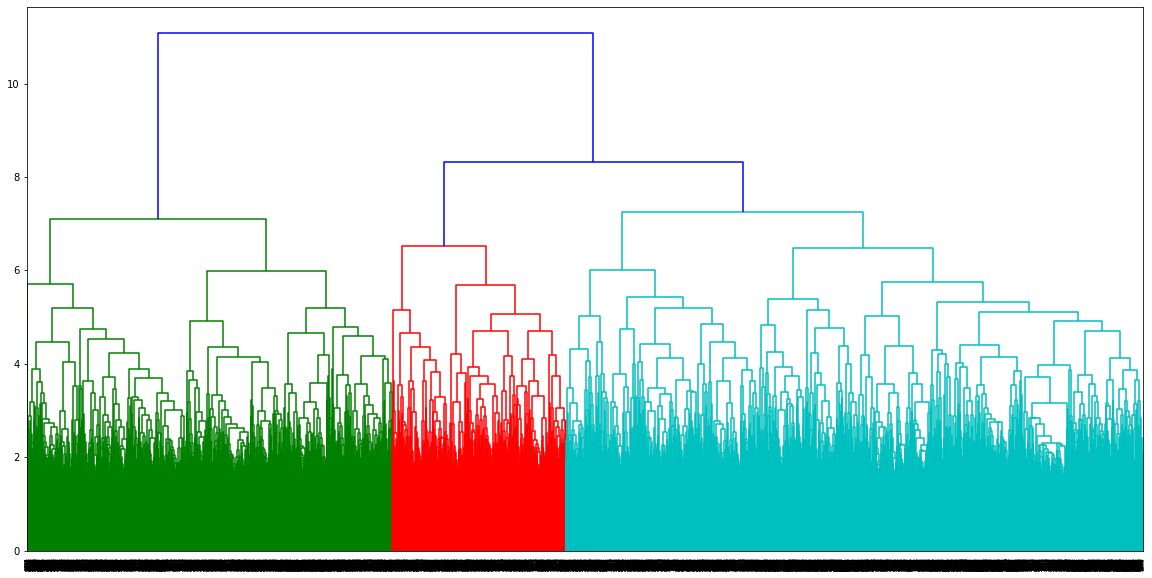

In [ ]:
y = netflix_bag_df['title']
X = netflix_cosine_sim
plt.figure(figsize=(20,10))
dendrogram(linkage(X, method='complete'))
plt.show()

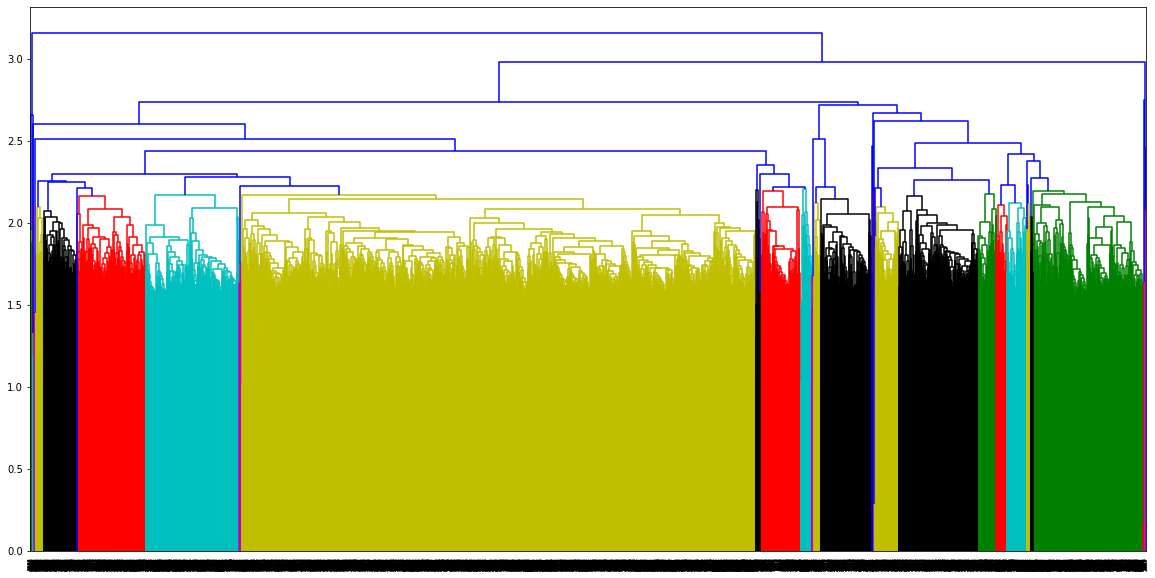

In [ ]:
y = netflix_bag_df['title']
X = netflix_tfidf_sim
plt.figure(figsize=(20,10))
dendrogram(linkage(X, method='complete'))
plt.show()

#The dendrogram on the TF-IDF vectorized data seems to have outperformed the dendrogram on the count vectorized data as it gives us 
# a larger number of groups to pull from for a recommendation. 

### DBSCAN

In [ ]:
y = netflix_bag_df['title']
X = netflix_cosine_sim

dbscan_cluster = DBSCAN(eps=1, min_samples=5)

# Fit model
clusters = dbscan_cluster.fit_predict(X)
print(metrics.silhouette_score(X, clusters, metric='euclidean'))
#This model is resulting in only 1 cluster. That is why I am geting this output.

ValueError: ignored

In [ ]:
y = netflix_bag_df['title']
X = netflix_tfidf_sim
dbscan_cluster = DBSCAN(eps=1, min_samples=5)

# Fit model
clusters = dbscan_cluster.fit_predict(X)
print(metrics.silhouette_score(X, clusters, metric='euclidean'))

ValueError: ignored

### Gaussian Mixture Models

In [ ]:
y = netflix_bag_df['title']
X = netflix_cosine_sim

gmm_cluster = GaussianMixture(n_components=3, random_state=123)

clusters = gmm_cluster.fit_predict(X)

print(metrics.silhouette_score(X, clusters, metric='euclidean'))

0.20093508274323993


In [ ]:
y = netflix_bag_df['title']
X = netflix_tfidf_sim
gmm_cluster = GaussianMixture(n_components=3, random_state=123)

clusters = gmm_cluster.fit_predict(X)

print(metrics.silhouette_score(X, clusters, metric='euclidean'))

0.02202162759979657


#Recommender 1 conclusion

The unsupervised tools do not perform well for this task. One problem is in the data type of the 'title' as well as the nature of the data in that column. It is a string, which is not ideal, or even useful, for these models. Furthermore, there are no 'groups' to be formed, other than our desire to have similar movies. 

The best way to evaluate the performance of this recommender is to do some research on the recommended titles and assess how similar they are to the original input. 

One thing to bare in mind about this data is that there is no metric to determine popularity. However, this would be a usful piece of information in making a recommender system. It would probably not be super useful to recommend a blockbuster film as most people will have already heard of them and may already have looked them up. An ideal system recommends movies that are similar to the input but bnot super popular. This way the system increases the likelihood of recommending a movie that the user has not heard of but may be interested in. 

# Genre Generator 

In [ ]:
df = netflix_df[['listed_in', 'description']]

df = df.astype(str)

#everything needs to be lowercase to avoid duplications

df['listed_in'] = df['listed_in'].str.lower()
df['description'] = df['description'].str.lower()


#Raking the descriptions

df['key_words'] = ""
for index, row in df.iterrows():
    plot = row['description']

    # instantiating Rake, by default it uses english stopwords from NLTK
    # and discards all puntuation characters as well
    r = Rake()

    # extracting the words by passing the text
    r.extract_keywords_from_text(plot)

    # getting the dictionary whith key words as keys and their scores as values
    key_words_dict_scores = r.get_word_degrees()

    # assigning the key words to the new column for the corresponding movie
    row['key_words'] = list(key_words_dict_scores.keys())

    # casting 'kew_words' to string
    s = row['key_words']
    listtojoin = ' '.join([str(elem) for elem in s])
    row['key_words'] = listtojoin

#df['bag_of_words'] = df[['type', 'cast', 'director', 'listed_in', 'key_words']].agg(''.join, axis=1)
genre_bag_df = df[['listed_in', 'key_words']]
#test_df.head()

genre_bag_df['listed_in_cat'] = LabelEncoder().fit_transform(genre_bag_df['listed_in'])
genre_cat_df = genre_bag_df[['listed_in_cat', 'listed_in']]
genre_bag_df

count = CountVectorizer()
genre_count_matrix = count.fit_transform(genre_bag_df['key_words'])

# generating the cosine similarity matrix
# To compute similarity between the user and item, we simply take the cosine similarity between the user vector and the item vector. 
# This gives us user-item similarity. This is useful in this case because the feature vectors are so close to the target vector.
genre_cosine_sim = cosine_similarity(genre_count_matrix, genre_count_matrix)

In [ ]:
print(r.get_ranked_phrases_with_scores())

[(9.0, 'hit sitcom follows'), (4.0, 'something pals'), (4.0, 'six 20'), (4.0, 'merry misadventures'), (4.0, '1990s manhattan'), (1.0, 'work'), (1.0, 'pitfalls'), (1.0, 'navigate'), (1.0, 'love'), (1.0, 'life')]


Because this has the labels already, they can be used to check how well the various models are at guessing genre

for the description, Rake() for key terms and vectorize the key terms

for the listed_in 1) leave the data as is and OneHotEncode. 2)

In [ ]:
df

,title,listed_in,description
0,Norm of the North: King Sized Adventure,"children & family movies, comedies",before planning an awesome wedding for his gra...
1,Jandino: Whatever it Takes,stand-up comedy,jandino asporaat riffs on the challenges of ra...
2,Transformers Prime,kids' tv,"with the help of three human allies, the autob..."
3,Transformers: Robots in Disguise,kids' tv,when a prison ship crash unleashes hundreds of...
4,#realityhigh,comedies,when nerdy high schooler dani finally attracts...
...,...,...,...
6229,Red vs. Blue,"tv action & adventure, tv comedies, tv sci-fi ...","this parody of first-person shooter games, mil..."
6230,Maron,tv comedies,"marc maron stars as marc maron, who interviews..."
6231,Little Baby Bum: Nursery Rhyme Friends,movies,nursery rhymes and original music for children...
6232,A Young Doctor's Notebook and Other Stories,"british tv shows, tv comedies, tv dramas","set during the russian revolution, this comic ..."


In [ ]:
len(df['listed_in'].unique())

461

In [ ]:
col = 'listed_in'
categories = ", ".join(netflix_df['listed_in']).split(', ')
categories = pd.DataFrame(categories)
categories[0].unique()

array(['Children & Family Movies', 'Comedies', 'Stand-Up Comedy',
       "Kids' TV", 'Crime TV Shows', 'International TV Shows',
       'Spanish-Language TV Shows', 'International Movies',
       'Sci-Fi & Fantasy', 'Thrillers', 'Docuseries',
       'Science & Nature TV', 'Action & Adventure', 'Dramas',
       'Cult Movies', 'Independent Movies', 'Romantic Movies',
       'Documentaries', 'Horror Movies', 'Romantic TV Shows',
       'TV Comedies', 'TV Dramas', 'TV Thrillers', 'TV Mysteries',
       'British TV Shows', 'Music & Musicals', 'Reality TV',
       'TV Action & Adventure', 'Anime Features', 'Teen TV Shows',
       'Faith & Spirituality', 'Korean TV Shows', 'Anime Series',
       'LGBTQ Movies', 'TV Horror', 'Movies',
       'Stand-Up Comedy & Talk Shows', 'TV Sci-Fi & Fantasy',
       'Classic Movies', 'Sports Movies', 'TV Shows', 'Classic & Cult TV'],
      dtype=object)

In [ ]:
#Raking the descriptions

df['key_words'] = ""
for index, row in df.iterrows():
    plot = row['description']

    # instantiating Rake, by default it uses english stopwords from NLTK
    # and discards all puntuation characters as well
    r = Rake()

    # extracting the words by passing the text
    r.extract_keywords_from_text(plot)

    # getting the dictionary whith key words as keys and their scores as values
    key_words_dict_scores = r.get_word_degrees()

    # assigning the key words to the new column for the corresponding movie
    row['key_words'] = list(key_words_dict_scores.keys())

    # casting 'kew_words' to string
    s = row['key_words']
    listtojoin = ' '.join([str(elem) for elem in s])
    row['key_words'] = listtojoin

#df['bag_of_words'] = df[['type', 'cast', 'director', 'listed_in', 'key_words']].agg(''.join, axis=1)
genre_bag_df = df[['listed_in', 'key_words']]
#test_df.head()

In [ ]:
genre_bag_df

,listed_in,key_words
0,"children & family movies, comedies",grandfather evil archaeologist first polar bea...
1,stand-up comedy,audience sex fire serenades jandino asporaat r...
2,kids' tv,decepticons autobots onslaught leader three hu...
3,kids' tv,decepticons bumblebee leads new autobot force ...
4,comedies,longtime crush lands nerdy high schooler dani ...
...,...,...
6229,"tv action & adventure, tv comedies, tv sci-fi ...",person shooter games science military life mid...
6230,tv comedies,neuroses relationships popular podcast marc ma...
6231,movies,nursery rhymes educate numbers shapes playful ...
6232,"british tv shows, tv comedies, tv dramas",set russian revolution comic miniseries based ...


In [ ]:
genre_bag_df['listed_in_cat'] = LabelEncoder().fit_transform(genre_bag_df['listed_in'])
genre_cat_df = genre_bag_df[['listed_in_cat', 'listed_in']]
genre_bag_df

,listed_in,key_words,listed_in_cat
0,"children & family movies, comedies",grandfather evil archaeologist first polar bea...,110
1,stand-up comedy,audience sex fire serenades jandino asporaat r...,420
2,kids' tv,decepticons autobots onslaught leader three hu...,381
3,kids' tv,decepticons bumblebee leads new autobot force ...,381
4,comedies,longtime crush lands nerdy high schooler dani ...,167
...,...,...,...
6229,"tv action & adventure, tv comedies, tv sci-fi ...",person shooter games science military life mid...,428
6230,tv comedies,neuroses relationships popular podcast marc ma...,436
6231,movies,nursery rhymes educate numbers shapes playful ...,396
6232,"british tv shows, tv comedies, tv dramas",set russian revolution comic miniseries based ...,104


In [ ]:
count = CountVectorizer()
genre_count_matrix = count.fit_transform(genre_bag_df['key_words'])

# generating the cosine similarity matrix
# To compute similarity between the user and item, we simply take the cosine similarity between the user vector and the item vector. 
# This gives us user-item similarity. This is useful in this case because the feature vectors are so close to the target vector.
genre_cosine_sim = cosine_similarity(genre_count_matrix, genre_count_matrix)

In [ ]:
genre_cosine_sim

In [ ]:
#Raking the descriptions

df['key_words'] = ""
for index, row in df.iterrows():
    plot = row['description']

    # instantiating Rake, by default it uses english stopwords from NLTK
    # and discards all puntuation characters as well
    r = Rake()

    # extracting the words by passing the text
    r.extract_keywords_from_text(plot)

    # getting the dictionary whith key words as keys and their scores as values
    key_words_dict_scores = r.get_word_degrees()

    # assigning the key words to the new column for the corresponding movie
    row['key_words'] = list(key_words_dict_scores.keys())

    # casting 'kew_words' to string
    s = row['key_words']
    listtojoin = ' '.join([str(elem) for elem in s])
    row['key_words'] = listtojoin

#df['bag_of_words'] = df[['type', 'cast', 'director', 'listed_in', 'key_words']].agg(''.join, axis=1)
genre_bag_df = df[['title','listed_in', 'key_words']]
#test_df.head()



#------
# instantiating and generating the count matrix
count = CountVectorizer()
genre_count_matrix = count.fit_transform(genre_bag_df['key_words'])

# generating the cosine similarity matrix
# To compute similarity between the user and item, we simply take the cosine similarity between the user vector and the item vector. 
# This gives us user-item similarity. This is useful in this case because the feature vectors are so close to the target vector.
genre_cosine_sim = cosine_similarity(genre_count_matrix, genre_count_matrix)


#------
# creating a Series for the movie titles so they are associated to an ordered numerical
# list I will use in the function to match the indexes
indices = pd.Series(genre_bag_df['title'])
#  defining the function that takes in movie title 
# as input and returns the top 10 recommended movies
def genre_count_generator(name):
    # initializing the empty list of recommended movies
    movie=[]
     # gettin the index of the movie that matches the title
    idx = indices[indices == name].index[0]
    # creating a Series with the similarity scores in descending order
    sort_index = pd.Series(genre_cosine_sim[idx]).sort_values(ascending = False)
    # getting the indexes of the 10 most similar movies
    top_10 = sort_index.iloc[1:11]
    # populating the list with the titles of the best 10 matching movies
    for i in top_10.index:
        movie.append(indices[i])
    return movie

In [ ]:
genre_count_generator('Transformers Prime')

['Transformers: Robots in Disguise',
 'Banana Island Ghost',
 "World's Busiest Cities",
 'Beyond Skyline',
 'The Matrix Reloaded',
 'New Girl',
 'Space Cowboys',
 'Steve Jobs',
 'Bad Guys',
 'Motor Mitraan Di']

In [ ]:
genre_bag_df

,title,listed_in,key_words
0,Norm of the North: King Sized Adventure,"children & family movies, comedies",grandfather awesome wedding polar bear king mu...
1,Jandino: Whatever it Takes,stand-up comedy,serenades rousing rendition audience fire chal...
2,Transformers Prime,kids' tv,protect earth three human allies autobots lead...
3,Transformers: Robots in Disguise,kids' tv,protect humankind earth prison ship crash unle...
4,#realityhigh,comedies,cross hairs interest social media celebrity ex...
...,...,...,...
6229,Red vs. Blue,"tv action & adventure, tv comedies, tv sci-fi ...",fiction films centers science desolate canyon ...
6230,Maron,tv comedies,interviews fellow comedians neuroses relations...
6231,Little Baby Bum: Nursery Rhyme Friends,movies,children accompanied original music playful an...
6232,A Young Doctor's Notebook and Other Stories,"british tv shows, tv comedies, tv dramas",doctor way village russian revolution comic mi...


In [ ]:


#------
# instantiating and generating the count matrix
count = CountVectorizer()
genre_count_matrix = count.fit_transform(genre_bag_df['key_words'])

# generating the cosine similarity matrix
# To compute similarity between the user and item, we simply take the cosine similarity between the user vector and the item vector. 
# This gives us user-item similarity. This is useful in this case because the feature vectors are so close to the target vector.
genre_cosine_sim = cosine_similarity(genre_count_matrix, genre_count_matrix)


#------
# creating a Series for the movie titles so they are associated to an ordered numerical
# list I will use in the function to match the indexes
indices = pd.Series(genre_bag_df['key_words'])
#  defining the function that takes in movie title 
# as input and returns the top 10 recommended movies
def genre_count_generator(name):
    # initializing the empty list of recommended movies
    movie=[]
     # gettin the index of the movie that matches the title
    idx = indices[indices == name].index[0]
    # creating a Series with the similarity scores in descending order
    sort_index = pd.Series(genre_cosine_sim[idx]).sort_values(ascending = False)
    # getting the indexes of the 10 most similar movies
    top_10 = sort_index.iloc[1:11]
    # populating the list with the titles of the best 10 matching movies
    for i in top_10.index:
        movie.append(indices[i])
    return movie


#-------

genre_tf_idf_df = df[['title','listed_in', 'key_words']]


vectorizer = TfidfVectorizer()
genre_vectors = vectorizer.fit_transform(genre_tf_idf_df['key_words'])

genre_tfidf_sim = cosine_similarity(genre_vectors, genre_vectors)
#feature_names = vectorizer.get_feature_names
#dense = vectors.todense()
#denselist = dense.tolist()
#tf_df = pd.DataFrame(denselist, columns=feature_names)
#tf_df
indices = pd.Series(genre_tf_idf_df['title'])
#  defining the function that takes in movie title 
# as input and returns the top 10 recommended movies
def genre_tfidf_generator(name):
    # initializing the empty list of recommended movies
    movie=[]
     # gettin the index of the movie that matches the title
    idx = indices[indices == name].index[0]
    # creating a Series with the similarity scores in descending order
    sort_index = pd.Series(genre_tfidf_sim[idx]).sort_values(ascending = False)
    # getting the indexes of the 10 most similar movies
    top_10 = sort_index.iloc[1:11]
    # populating the list with the titles of the best 10 matching movies
    for i in top_10.index:
        movie.append(indices[i])
    return movie

#Recommender 2 - movie_df

### Content Based Filtering

The netflix_df is limited because it has no initial ground truth, i.e. no metric, with which to compare the output to. The second dataset to be used, movie_df, was taken from kaggle. It contains movies titles, their rating from IMDb and Rotten Tomatoes as well as the steaming platform(Hulu, Netflix, etc.) that the movie or show can be found on. The focus of part 2 will be to find similar movies based on the information in movie_df and measure how accurate the system is using the rating from IMDb and Rotten Tomatos as our metic of comparison.
 

I began by first replicating the recommender system from Recommender 1. As before, this outputs a list of 10 movies that most closely resemble the imput movie based on the criteria used in the program.

In [ ]:
master_movie_df.head()
#Raking can be done on Directors and Genre, I am not sure how useful that will be. 

,Unnamed: 0,ID,Title,Year,Age,IMDb,Rotten Tomatoes,Netflix,Hulu,Prime Video,Disney+,Type,Directors,Genres,Country,Language,Runtime
0,0,1,Inception,2010,13+,8.8,87%,1,0,0,0,0,Christopher Nolan,"Action,Adventure,Sci-Fi,Thriller","United States,United Kingdom","English,Japanese,French",148.0
1,1,2,The Matrix,1999,18+,8.7,87%,1,0,0,0,0,"Lana Wachowski,Lilly Wachowski","Action,Sci-Fi",United States,English,136.0
2,2,3,Avengers: Infinity War,2018,13+,8.5,84%,1,0,0,0,0,"Anthony Russo,Joe Russo","Action,Adventure,Sci-Fi",United States,English,149.0
3,3,4,Back to the Future,1985,7+,8.5,96%,1,0,0,0,0,Robert Zemeckis,"Adventure,Comedy,Sci-Fi",United States,English,116.0
4,4,5,"The Good, the Bad and the Ugly",1966,18+,8.8,97%,1,0,1,0,0,Sergio Leone,Western,"Italy,Spain,West Germany",Italian,161.0


In [ ]:
master_movie_df.info()
#Rotten Tomato = 5158/16744
#IMDb has = 16173/16744
#Directors = 16018/16744
#Genres = 16469/16744
#Type = 1/1
#The Rotten Tomato score will be removed entirely for the algorithm. However, it may be useful later as it could indicate
#popular movies simply based on the fact that RT took the time to review it. 

#For now, I will run the model on all possible IMDb ratings. 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16744 entries, 0 to 16743
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Unnamed: 0       16744 non-null  int64  
 1   ID               16744 non-null  int64  
 2   Title            16744 non-null  object 
 3   Year             16744 non-null  int64  
 4   Age              7354 non-null   object 
 5   IMDb             16173 non-null  float64
 6   Rotten Tomatoes  5158 non-null   object 
 7   Netflix          16744 non-null  int64  
 8   Hulu             16744 non-null  int64  
 9   Prime Video      16744 non-null  int64  
 10  Disney+          16744 non-null  int64  
 11  Type             16744 non-null  int64  
 12  Directors        16018 non-null  object 
 13  Genres           16469 non-null  object 
 14  Country          16309 non-null  object 
 15  Language         16145 non-null  object 
 16  Runtime          16152 non-null  float64
dtypes: float64(2

In [ ]:
movie_df = master_movie_df[['Title', 'IMDb', 'Directors', 'Genres', 'Type']]
movie_df = movie_df.dropna()
movie_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15666 entries, 0 to 16742
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Title      15666 non-null  object 
 1   IMDb       15666 non-null  float64
 2   Directors  15666 non-null  object 
 3   Genres     15666 non-null  object 
 4   Type       15666 non-null  int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 734.3+ KB


In [ ]:
movie_df = master_movie_df[['Title', 'IMDb', 'Directors', 'Genres', 'Type']]
movie_df = movie_df.dropna()

movie_df['Directors'] = movie_df['Directors'].apply(lambda x: x.replace(' ','')).str.lower()
movie_df['Genres'] = movie_df['Genres'].apply(lambda x: x.replace('-', '')).str.lower()
movie_df['Genres'] = movie_df['Genres'].apply(lambda x: x.replace(',', ' ')).str.lower()

movie_df = movie_df.astype(str)

#-----

movie_df['new_col'] = movie_df[['Directors', 'Genres']].agg(' '.join, axis=1)
movie_df['key_words'] = ""
for index, row in movie_df.iterrows():
    plot = row['new_col']

    # instantiating Rake, by default it uses english stopwords from NLTK
    # and discards all puntuation characters as well
    r = Rake()

    # extracting the words by passing the text
    r.extract_keywords_from_text(plot)

    # getting the dictionary whith key words as keys and their scores as values
    key_words_dict_scores = r.get_word_degrees()

    # assigning the key words to the new column for the corresponding movie
    row['key_words'] = list(key_words_dict_scores.keys())
    
    # casting the 'key_words' to strings
    s = row['key_words']
    listtojoin = ' '.join([str(elem) for elem in s])
    row['key_words'] = listtojoin

#movie_df['bag_of_words'] = movie_df[['Directors', 'key_words']].agg(','.join, axis=1)
movie_bag_df = movie_df[['Title','Type','IMDb', 'key_words']]




#------

# instantiating and generating the count matrix
count = CountVectorizer()
movie_count_matrix = count.fit_transform(movie_bag_df['key_words'])

# generating the cosine similarity matrix
movie_cosine_sim = cosine_similarity(movie_count_matrix, movie_count_matrix)


#------

# creating a Series for the movie titles so they are associated to an ordered numerical
# list I will use in the function to match the indexes
indices = pd.Series(movie_bag_df['Title'])
#  defining the function that takes in movie title 
# as input and returns the top 10 recommended movies
def movie_count_recommend_movie(name):
    # initializing the empty list of recommended movies
    movie=[]
     # gettin the index of the movie that matches the title
    idx = indices[indices == name].index[0]
    # creating a Series with the similarity scores in descending order
    sort_index = pd.Series(movie_cosine_sim[idx]).sort_values(ascending = False)
    # getting the indexes of the 10 most similar movies
    top_10 = sort_index.iloc[1:11]
    # populating the list with the titles of the best 10 matching movies
    for i in top_10.index:
        movie.append(indices[i])
    return movie


#------

tf_idf_df = movie_df[['Title','Type','IMDb', 'key_words']]


vectorizer = TfidfVectorizer()
movie_vectors = vectorizer.fit_transform(tf_idf_df['key_words'])

movie_tfidf_sim = cosine_similarity(movie_vectors, movie_vectors)
#feature_names = vectorizer.get_feature_names
#dense = vectors.todense()
#denselist = dense.tolist()
#tf_df = pd.DataFrame(denselist, columns=feature_names)
#tf_df
indices = pd.Series(tf_idf_df['Title'])
#  defining the function that takes in movie title 
# as input and returns the top 10 recommended movies
def movie_tfidf_recommend_movie(name):
    # initializing the empty list of recommended movies
    movie=[]
     # gettin the index of the movie that matches the title
    idx = indices[indices == name].index[0]
    # creating a Series with the similarity scores in descending order
    sort_index = pd.Series(movie_tfidf_sim[idx]).sort_values(ascending = False)
    # getting the indexes of the 10 most similar movies
    top_10 = sort_index.iloc[1:11]
    # populating the list with the titles of the best 10 matching movies
    for i in top_10.index:
        movie.append(indices[i])
    return movie

NameError: ignored

In [ ]:
movie_count_recommend_movie('The Matrix')

['The Matrix',
 'Lagaan: Once Upon a Time in India',
 '47 Meters Down',
 'Vegas in Space',
 'Sing Sing Nights',
 'Soft Money',
 '10x10',
 'Maya Memsaab',
 'Lacchimdeviki O Lekkundi',
 'Jury of Our Peers']

In [ ]:
movie_tfidf_recommend_movie('The Matrix')

['Lagaan: Once Upon a Time in India',
 'Madagascar: Escape 2 Africa',
 '47 Meters Down',
 "A Wife's Nightmare",
 'Desert Victory',
 'Brothers of War',
 'Not Another Zombie Movie....About the Living Dead',
 'Nathicharami',
 'Let the Balloon Go',
 'Blank Generation']

# Recommender 3 - movie_df

### Collaborative Based Filtering 

In this section I will emulate a collaborative filter with the movie_df. The IMDb coumns will represent 'other users' data' and the Rotten Tomatoes will represent the 'current user'. This will allow for a mentic that can be used as a unit of comparison.

# Mentor Question - Does this reallt need to be done?

#K-Means

K-Means is useful 

In [ ]:
master_movie_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16744 entries, 0 to 16743
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Unnamed: 0       16744 non-null  int64  
 1   ID               16744 non-null  int64  
 2   Title            16744 non-null  object 
 3   Year             16744 non-null  int64  
 4   Age              7354 non-null   object 
 5   IMDb             16173 non-null  float64
 6   Rotten Tomatoes  5158 non-null   object 
 7   Netflix          16744 non-null  int64  
 8   Hulu             16744 non-null  int64  
 9   Prime Video      16744 non-null  int64  
 10  Disney+          16744 non-null  int64  
 11  Type             16744 non-null  int64  
 12  Directors        16018 non-null  object 
 13  Genres           16469 non-null  object 
 14  Country          16309 non-null  object 
 15  Language         16145 non-null  object 
 16  Runtime          16152 non-null  float64
dtypes: float64(2

In [ ]:
master_movie_df.head()

,Unnamed: 0,ID,Title,Year,Age,IMDb,Rotten Tomatoes,Netflix,Hulu,Prime Video,Disney+,Type,Directors,Genres,Country,Language,Runtime
0,0,1,Inception,2010,13+,8.8,87%,1,0,0,0,0,Christopher Nolan,"Action,Adventure,Sci-Fi,Thriller","United States,United Kingdom","English,Japanese,French",148.0
1,1,2,The Matrix,1999,18+,8.7,87%,1,0,0,0,0,"Lana Wachowski,Lilly Wachowski","Action,Sci-Fi",United States,English,136.0
2,2,3,Avengers: Infinity War,2018,13+,8.5,84%,1,0,0,0,0,"Anthony Russo,Joe Russo","Action,Adventure,Sci-Fi",United States,English,149.0
3,3,4,Back to the Future,1985,7+,8.5,96%,1,0,0,0,0,Robert Zemeckis,"Adventure,Comedy,Sci-Fi",United States,English,116.0
4,4,5,"The Good, the Bad and the Ugly",1966,18+,8.8,97%,1,0,1,0,0,Sergio Leone,Western,"Italy,Spain,West Germany",Italian,161.0


In [ ]:
colab_df = master_movie_df[['Title', 'IMDb', 'Directors', 'Genres', 'Type']]
user_df = master_movie_df[['Title', 'Rotten Tomatoes']]

#TF-IDF - UNUSED IN NOTEBOOK

Term Frequency is the number of times a word appears in a document divided by the total number of words in that document. 

Inverse Data Frequency is the log of the number of documents divided by the number of documents that contain the word w. Inverse data frequency determines the weight of rare words across all documents in the corpus.

This method does not seem to be ideal for this situation. When I run it on 'strings' it crashes. Also, as noted below, it breaks after every space. In order to keep multi-word features together, feature engineering would be needed to remove all spaces and characters that cause the algorithm to seperate.
#mentor question. How is 'document' being used in this sentence?

In [ ]:

tf_idf_df = movie_df[['Title','Type','IMDb', 'key_words']]


vectorizer = TfidfVectorizer()
vectors = vectorizer.fit_transform(tf_idf_df['key_words'])

cosine_sim = cosine_similarity(vectors, vectors)
#feature_names = vectorizer.get_feature_names
#dense = vectors.todense()
#denselist = dense.tolist()
#tf_df = pd.DataFrame(denselist, columns=feature_names)
#tf_df
indices = pd.Series(tf_idf_df['Title'])
#  defining the function that takes in movie title 
# as input and returns the top 10 recommended movies
def movie_tfidf_recommend_movie(name):
    # initializing the empty list of recommended movies
    movie=[]
     # gettin the index of the movie that matches the title
    idx = indices[indices == name].index[0]
    # creating a Series with the similarity scores in descending order
    sort_index = pd.Series(cosine_sim[idx]).sort_values(ascending = False)
    # getting the indexes of the 10 most similar movies
    top_10 = sort_index.iloc[1:11]
    # populating the list with the titles of the best 10 matching movies
    for i in top_10.index:
        movie.append(indices[i])
    return movie

In [ ]:
movie_tfidf_recommend_movie('The Matrix')

['Lagaan: Once Upon a Time in India',
 'Madagascar: Escape 2 Africa',
 '47 Meters Down',
 "A Wife's Nightmare",
 'Desert Victory',
 'Brothers of War',
 'Not Another Zombie Movie....About the Living Dead',
 'Nathicharami',
 'Let the Balloon Go',
 'Blank Generation']

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:

#select column
col = 'listed_in'
categories = ", ".join(netflix_df['listed_in']).split(', ')
categories
#this method of changing the strings in not going to work because it creates a list with all the strings used in one list,
#it will be impossible to link any input with this set up to a recommendation
vectorizer = TfidfVectorizer()

vectors = vectorizer.fit_transform(categories)

feature_names = vectorizer.get_feature_names()

dense = vectors.todense()

denselist = dense.tolist()

tf_df_1 = pd.DataFrame(denselist, columns=feature_names)
tf_df_1

,action,adventure,anime,british,children,classic,comedies,comedy,crime,cult,documentaries,docuseries,dramas,faith,family,fantasy,features,fi,horror,independent,international,kids,korean,language,lgbtq,movies,music,musicals,mysteries,nature,reality,romantic,sci,science,series,shows,spanish,spirituality,sports,stand,talk,teen,thrillers,tv,up
0,0.0,0.0,0.0,0.000000,0.667967,0.000000,0.000000,0.00000,0.0,0.00000,0.0,0.0,0.000000,0.0,0.667967,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.328084,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.00000
1,0.0,0.0,0.0,0.000000,0.000000,0.000000,1.000000,0.00000,0.0,0.00000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.00000
2,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.57735,0.0,0.00000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.57735,0.0,0.0,0.0,0.000000,0.57735
3,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.00000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.906731,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.421709,0.00000
4,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.00000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.906731,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.421709,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13665,0.0,0.0,0.0,0.822062,0.000000,0.000000,0.000000,0.00000,0.0,0.00000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.449524,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.349488,0.00000
13666,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.822316,0.00000,0.0,0.00000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.569031,0.00000
13667,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.00000,0.0,0.0,0.788279,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.615318,0.00000
13668,0.0,0.0,0.0,0.000000,0.000000,0.666517,0.000000,0.00000,0.0,0.70187,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.251266,0.00000


In [ ]:
#categories

In [ ]:
col = 'listed_in'
df_5 = pd.DataFrame(", ".join(netflix_df['listed_in']).split(', '))
df_5[0] = df_5[0].str.replace(' ','')
df_5[0] = df_5[0].str.replace('-','')
df_5[0] = df_5[0].str.replace("'",'')
cat_list = df_5[0].values.tolist()
##this method of changing the strings in not going to work because it creates a list with all the strings used in one list,
#it will be impossible to link any input with this set up to a recommendation
vectorizer = TfidfVectorizer()

vectors = vectorizer.fit_transform(cat_list)

feature_names = vectorizer.get_feature_names()

dense = vectors.todense()

denselist = dense.tolist()

tf_df_2 = pd.DataFrame(denselist, columns=feature_names)
tf_df_2


,action,adventure,animefeatures,animeseries,britishtvshows,children,classic,classicmovies,comedies,crimetvshows,cultmovies,culttv,documentaries,docuseries,dramas,faith,familymovies,fantasy,horrormovies,independentmovies,internationalmovies,internationaltvshows,kidstv,koreantvshows,lgbtqmovies,movies,music,musicals,naturetv,realitytv,romanticmovies,romantictvshows,science,scifi,spanishlanguagetvshows,spirituality,sportsmovies,standupcomedy,talkshows,teentvshows,thrillers,tvaction,tvcomedies,tvdramas,tvhorror,tvmysteries,tvscifi,tvshows,tvthrillers
0,0.0,0.0,0.0,0.0,0.0,0.707107,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.707107,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,1.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13665,0.0,0.0,0.0,0.0,1.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13666,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
13667,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
13668,0.0,0.0,0.0,0.0,0.0,0.000000,0.707107,0.0,0.0,0.0,0.0,0.707107,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
df_5[0].unique()

array(['Children&FamilyMovies', 'Comedies', 'StandUpComedy', 'KidsTV',
       'CrimeTVShows', 'InternationalTVShows', 'SpanishLanguageTVShows',
       'InternationalMovies', 'SciFi&Fantasy', 'Thrillers', 'Docuseries',
       'Science&NatureTV', 'Action&Adventure', 'Dramas', 'CultMovies',
       'IndependentMovies', 'RomanticMovies', 'Documentaries',
       'HorrorMovies', 'RomanticTVShows', 'TVComedies', 'TVDramas',
       'TVThrillers', 'TVMysteries', 'BritishTVShows', 'Music&Musicals',
       'RealityTV', 'TVAction&Adventure', 'AnimeFeatures', 'TeenTVShows',
       'Faith&Spirituality', 'KoreanTVShows', 'AnimeSeries',
       'LGBTQMovies', 'TVHorror', 'Movies', 'StandUpComedy&TalkShows',
       'TVSciFi&Fantasy', 'ClassicMovies', 'SportsMovies', 'TVShows',
       'Classic&CultTV'], dtype=object)

In [ ]:
df_3 = pd.DataFrame(netflix_df['listed_in'].apply(lambda x: x.split(',')))
#df_3['listed_in'] = df_3['listed_in'].str.replace(' ','')
#df_3['listed_in'] = df_3['listed_in'].str.replace('-','')
#df_3['listed_in'] = df_3['listed_in'].str.replace("'",'')
cat_list = df_3['listed_in'].astype(str)
#this method does not work well with the .replace() function. 
vectorizer = TfidfVectorizer()

vectors = vectorizer.fit_transform(cat_list)

feature_names = vectorizer.get_feature_names()

dense = vectors.todense()

denselist = dense.tolist()

tf_df_3 = pd.DataFrame(denselist, columns=feature_names)
tf_df_3

,action,adventure,anime,british,children,classic,comedies,comedy,crime,cult,documentaries,docuseries,dramas,faith,family,fantasy,features,fi,horror,independent,international,kids,korean,language,lgbtq,movies,music,musicals,mysteries,nature,reality,romantic,sci,science,series,shows,spanish,spirituality,sports,stand,talk,teen,thrillers,tv,up
0,0.000000,0.000000,0.0,0.000000,0.620449,0.000000,0.390503,0.00000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.620449,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.278556,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.00000
1,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.57735,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.57735,0.0,0.0,0.0,0.000000,0.57735
2,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.874011,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.485907,0.00000
3,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.874011,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.485907,0.00000
4,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,1.000000,0.00000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6229,0.286666,0.286666,0.0,0.000000,0.000000,0.000000,0.217460,0.00000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.379076,0.0,0.379076,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.379076,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.597713,0.00000
6230,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.737324,0.00000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.675539,0.00000
6231,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.00000
6232,0.000000,0.000000,0.0,0.494274,0.000000,0.000000,0.269550,0.00000,0.0,0.000000,0.0,0.0,0.228913,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.285872,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.740886,0.00000


In [ ]:
cat_list

0               ['Children & Family Movies', ' Comedies']
1                                     ['Stand-Up Comedy']
2                                            ["Kids' TV"]
3                                            ["Kids' TV"]
4                                            ['Comedies']
                              ...                        
6229    ['TV Action & Adventure', ' TV Comedies', ' TV...
6230                                      ['TV Comedies']
6231                                           ['Movies']
6232    ['British TV Shows', ' TV Comedies', ' TV Dram...
6233                ['Classic & Cult TV', ' TV Comedies']
Name: listed_in, Length: 6234, dtype: object

#Workspace

In [ ]:
bag = ''
test_df['bag_of_words'].iloc[:1]

0    Movie, Richard Finn, Tim Maltby, Alan Marriott...
Name: bag_of_words, dtype: object

'0    Movie, Richard Finn, Tim Maltby, Alan Marriott...'

In [ ]:
r = Rake()

In [ ]:
r.extract_keywords_from_text(plot)

In [ ]:
!pip install rake_nltk
from rake_nltk import Rake


  Created wheel for rake-nltk: filename=rake_nltk-1.0.4-py2.py3-none-any.whl size=7819 sha256=c27f29e60bc2dadbdbcbd959e98ffe497bbb3c3a2ecf4c6c8c6d45ae2e76b8b9
  Stored in directory: /root/.cache/pip/wheels/ef/92/fc/271b3709e71a96ffe934b27818946b795ac6b9b8ff8682483f
Successfully built rake-nltk


In [ ]:
r = Rake()

In [ ]:
plot = test_df['new_col'].iloc[:1]
r.extract_keywords_from_text(plot)

TypeError: ignored

In [ ]:
test_df = test_df.astype(str)

In [ ]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6234 entries, 0 to 6233
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       6234 non-null   object
 1   type          6234 non-null   object
 2   title         6234 non-null   object
 3   director      6234 non-null   object
 4   cast          6234 non-null   object
 5   country       6234 non-null   object
 6   date_added    6234 non-null   object
 7   release_year  6234 non-null   object
 8   rating        6234 non-null   object
 9   duration      6234 non-null   object
 10  listed_in     6234 non-null   object
 11  description   6234 non-null   object
dtypes: object(12)
memory usage: 584.6+ KB


In [ ]:
test_df['new_col'] = test_df[['listed_in', 'cast', 'rating', 'director', 'duration', 'description', 'type']].agg(', '.join, axis=1)

In [ ]:
test_df.iloc[:1]

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,new_col
0,81145628,Movie,Norm of the North: King Sized Adventure,"Richard Finn, Tim Maltby","Alan Marriott, Andrew Toth, Brian Dobson, Cole...","United States, India, South Korea, China","September 9, 2019",2019,TV-PG,90 min,"Children & Family Movies, Comedies",Before planning an awesome wedding for his gra...,"Children & Family Movies, Comedies, Alan Marri..."


In [ ]:
test_df = netflix_df.copy()
test_df.iloc[1,:].to_string(header=False, index=False)

In [ ]:
test_df['listed_in'] = test_df['listed_in'].to_string()
test_df['cast'] = test_df['cast'].to_string()

test_df['str_col'] = test_df[['listed_in', 'cast']].agg(', '.join, axis=1)

In [ ]:
test_df['str_col'].iloc[1,]

'0                      Children & Family Movies, Comedies\n1                                         Stand-Up Comedy\n2                                                Kids\' TV\n3                                                Kids\' TV\n4                                                Comedies\n5       Crime TV Shows, International TV Shows, Spanis...\n6       International Movies, Sci-Fi & Fantasy, Thrillers\n7                                         Stand-Up Comedy\n8                         Docuseries, Science & Nature TV\n9                           Action & Adventure, Thrillers\n10                                        Stand-Up Comedy\n11       Action & Adventure, Dramas, International Movies\n12                               Children & Family Movies\n13                               Children & Family Movies\n14                               Children & Family Movies\n15                               Children & Family Movies\n16                               Children & Family Mo

In [ ]:
test_df['new_col']  = test_df['listed_in'].astype(str) + test_df['cast'].astype(str)
test_df['str_col'] = test_df[['listed_in', 'cast']].agg(''.join, axis=1)

TypeError: ignored

In [ ]:
new_df = netflix_df.copy()

In [ ]:
new_df['bag_of_word']= ''
for index,row in new_df.iterrows():
    plot = row['description']
    r = Rake()
    r.extract_keywords_from_text(plot)
    keyword_score = r.get_word_degrees()
    g = ''.join(row['listed_in'].split(',')).lower()
    d = ''.join(row['director'].replace(' ','').split(',')).lower()
    a = ' '.join(row['cast'].replace(' ','').split(',')).lower()
    k = ' '.join(list(keyword_score.keys()))
    row['bag_of_word'] = g + ' ' + ' ' + d + ' ' + a + ' ' + k

mydf = new_df[['title','bag_of_word']]
mydf.head()

AttributeError: ignored

In [ ]:
x = df.DataFrame(netflix_df['rating'].value_counts())
x

AttributeError: ignored

In [ ]:
col = 'listed_in'
categories = ", ".join(netflix_df['listed_in']).split(', ')
categories

['Children & Family Movies',
 'Comedies',
 'Stand-Up Comedy',
 "Kids' TV",
 "Kids' TV",
 'Comedies',
 'Crime TV Shows',
 'International TV Shows',
 'Spanish-Language TV Shows',
 'International Movies',
 'Sci-Fi & Fantasy',
 'Thrillers',
 'Stand-Up Comedy',
 'Docuseries',
 'Science & Nature TV',
 'Action & Adventure',
 'Thrillers',
 'Stand-Up Comedy',
 'Action & Adventure',
 'Dramas',
 'International Movies',
 'Children & Family Movies',
 'Children & Family Movies',
 'Children & Family Movies',
 'Children & Family Movies',
 'Children & Family Movies',
 'Children & Family Movies',
 'Children & Family Movies',
 'Cult Movies',
 'Dramas',
 'Independent Movies',
 'Comedies',
 'Independent Movies',
 'Romantic Movies',
 'Action & Adventure',
 'Comedies',
 'International Movies',
 'Documentaries',
 'Horror Movies',
 'Thrillers',
 'Dramas',
 'Independent Movies',
 'Dramas',
 'Independent Movies',
 'Romantic Movies',
 'International TV Shows',
 'Romantic TV Shows',
 'TV Comedies',
 'Documentaries

In [ ]:
genre = netflix_df['listed_in']
genre = genre.values
list_genre = []
for g in genre:
    for i in g.split(','):
        list_genre.append(i.strip())

list(set(list_genre))

['Crime TV Shows',
 'Music & Musicals',
 'International TV Shows',
 'Romantic TV Shows',
 'Action & Adventure',
 'TV Comedies',
 'Teen TV Shows',
 'TV Mysteries',
 'Docuseries',
 'TV Action & Adventure',
 'LGBTQ Movies',
 'Movies',
 'Sports Movies',
 'Comedies',
 'Korean TV Shows',
 'Spanish-Language TV Shows',
 "Kids' TV",
 'Dramas',
 'Classic & Cult TV',
 'Independent Movies',
 'Romantic Movies',
 'Thrillers',
 'Horror Movies',
 'Stand-Up Comedy',
 'TV Sci-Fi & Fantasy',
 'British TV Shows',
 'TV Shows',
 'Sci-Fi & Fantasy',
 'Children & Family Movies',
 'Reality TV',
 'Faith & Spirituality',
 'International Movies',
 'Stand-Up Comedy & Talk Shows',
 'Documentaries',
 'TV Horror',
 'Anime Series',
 'Anime Features',
 'Classic Movies',
 'TV Thrillers',
 'Science & Nature TV',
 'Cult Movies',
 'TV Dramas']

In [ ]:
netflix_df

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,81145628,Movie,Norm of the North: King Sized Adventure,"Richard Finn, Tim Maltby","Alan Marriott, Andrew Toth, Brian Dobson, Cole...","United States, India, South Korea, China","September 9, 2019",2019,TV-PG,90 min,"Children & Family Movies, Comedies",Before planning an awesome wedding for his gra...
1,80117401,Movie,Jandino: Whatever it Takes,NaN,Jandino Asporaat,United Kingdom,"September 9, 2016",2016,TV-MA,94 min,Stand-Up Comedy,Jandino Asporaat riffs on the challenges of ra...
2,70234439,TV Show,Transformers Prime,NaN,"Peter Cullen, Sumalee Montano, Frank Welker, J...",United States,"September 8, 2018",2013,TV-Y7-FV,1 Season,Kids' TV,"With the help of three human allies, the Autob..."
3,80058654,TV Show,Transformers: Robots in Disguise,NaN,"Will Friedle, Darren Criss, Constance Zimmer, ...",United States,"September 8, 2018",2016,TV-Y7,1 Season,Kids' TV,When a prison ship crash unleashes hundreds of...
4,80125979,Movie,#realityhigh,Fernando Lebrija,"Nesta Cooper, Kate Walsh, John Michael Higgins...",United States,"September 8, 2017",2017,TV-14,99 min,Comedies,When nerdy high schooler Dani finally attracts...
...,...,...,...,...,...,...,...,...,...,...,...,...
6229,80000063,TV Show,Red vs. Blue,NaN,"Burnie Burns, Jason Saldaña, Gustavo Sorola, G...",United States,NaN,2015,NR,13 Seasons,"TV Action & Adventure, TV Comedies, TV Sci-Fi ...","This parody of first-person shooter games, mil..."
6230,70286564,TV Show,Maron,NaN,"Marc Maron, Judd Hirsch, Josh Brener, Nora Zeh...",United States,NaN,2016,TV-MA,4 Seasons,TV Comedies,"Marc Maron stars as Marc Maron, who interviews..."
6231,80116008,Movie,Little Baby Bum: Nursery Rhyme Friends,NaN,NaN,NaN,NaN,2016,NaN,60 min,Movies,Nursery rhymes and original music for children...
6232,70281022,TV Show,A Young Doctor's Notebook and Other Stories,NaN,"Daniel Radcliffe, Jon Hamm, Adam Godley, Chris...",United Kingdom,NaN,2013,TV-MA,2 Seasons,"British TV Shows, TV Comedies, TV Dramas","Set during the Russian Revolution, this comic ..."


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



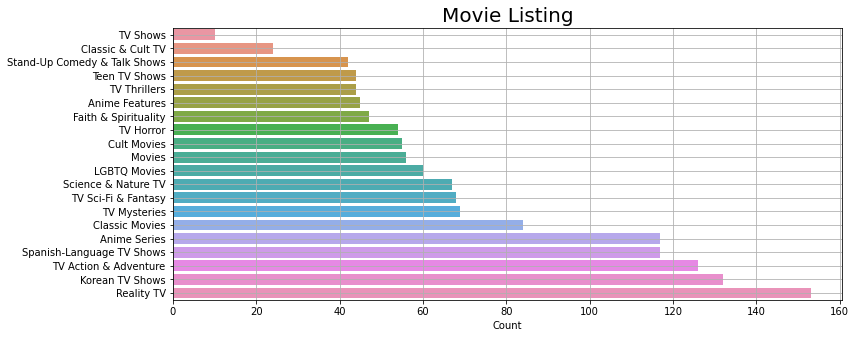

In [ ]:
import plotly.graph_objects as go
from collections import Counter
col = "listed_in"
categories = ", ".join(netflix_df['listed_in']).split(", ")
counter_list = Counter(categories).most_common(50)
labels = [_[0] for _ in counter_list][::-1]
values = [_[1] for _ in counter_list][::-1]
plt.figure(figsize=(12,5))
sns.barplot(values[0:20],labels[0:20]);
plt.xlabel('Count',fontsize=10)
#plt.ylabel('',fontsize=20)
plt.title('Movie Listing',fontsize=20)
#ax.tick_params(labelsize=20)
plt.grid()
plt.ioff()

In [ ]:
netflix_df[netflix_df['listed_in'] == 'Movies']

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
211,70129452,Movie,Louis C.K.: Hilarious,Louis C.K.,Louis C.K.,United States,"September 16, 2016",2010,NaN,84 min,Movies,Emmy-winning comedy writer Louis C.K. brings h...
222,81131761,Movie,The Outsider,Timothy Woodward Jr.,"Jon Foo, Trace Adkins, Sean Patrick Flanery, K...",United States,"September 15, 2019",2019,TV-MA,86 min,Movies,A frontier sheriff tries to protect his sadist...
628,80226951,Movie,"Club de Cuervos Presents: I, Potro",Marcos Bucay,"Joaquín Ferreira, Marcela Álvarez, Benjamín Al...","Mexico, Argentina","October 19, 2018",2018,TV-MA,51 min,Movies,Former Club de Cuervos player Potro returns ho...
629,80216677,Movie,Derren Brown: Sacrifice,NaN,Derren Brown,NaN,"October 19, 2018",2018,TV-MA,50 min,Movies,Illusionist Derren Brown concocts a psychologi...
633,81031037,Movie,Oddbods: Party Monsters,NaN,"Nadia Ramlee, Chio Su-Ping, Jeremy Linn, Marlo...",NaN,"October 19, 2018",2018,TV-Y,23 min,Movies,"Dressed up as detective Sherlock Holmes, Slick..."
980,80006232,Movie,Pac's Scary Halloween,NaN,"Erin Mathews, Sam Vincent, Andrea Libman, Ashl...",NaN,"October 1, 2016",2016,TV-Y7,44 min,Movies,When sinister Dr. Pacenstein schemes to swap b...
1107,81035121,Movie,True: Winter Wishes,NaN,"Michela Luci, Jamie Watson, Eric Peterson, Ann...",NaN,"November 26, 2019",2019,TV-Y,46 min,Movies,An ice crystal from a frosty realm is freezing...
1204,81215856,Movie,100 Things to do Before High School,NaN,"Isabela Moner, Jaheem Toombs, Owen Joyner, Jac...",United States,"November 2, 2019",2014,TV-G,44 min,Movies,"Led by seventh-grader C.J., three students who..."
1294,81028556,Movie,Shopkins: Chef Club,Raymond McGrath,"Erika Harlacher, Marieve Herington, David Lodg...",United States,"November 15, 2018",2016,TV-Y,45 min,Movies,"In this first full Shopkins movie, Peppa-Mint ..."
1295,81028574,Movie,Shopkins: Wild,"Adele K. Thomas, Richard Bailey","Kate Murphy, Cassandra Morris, Kayli Mills, Ab...",Australia,"November 15, 2018",2018,TV-Y,75 min,Movies,Beloved movie star Scarletta Gateau visits Sho...


In [ ]:
test_df = netflix_df[['type','title','listed_in', 'duration', 'rating']]

In [ ]:
df = pd.DataFrame(test_df['listed_in'].apply(lambda x: x.split(',')[0]))
df

,listed_in
0,Children & Family Movies
1,Stand-Up Comedy
2,Kids' TV
3,Kids' TV
4,Comedies
...,...
6229,TV Action & Adventure
6230,TV Comedies
6231,Movies
6232,British TV Shows


In [ ]:
df_2 = pd.DataFrame(test_df['listed_in'].apply(lambda x: x.split(',')[1]))
df_2

IndexError: ignored

In [ ]:
from collections import Counter

df = pd.DataFrame(netflix_df['listed_in'].apply(lambda x : x.split(',')[0]))

genres=list(df['listed_in'])
gen=[]

for i in genres:
    i=list(i.split(','))
    for j in i:
        gen.append(j.replace(' ',""))
g=Counter(gen)

In [ ]:
df['listed_in'].unique()

array(['Children & Family Movies', 'Stand-Up Comedy', "Kids' TV",
       'Comedies', 'Crime TV Shows', 'International Movies', 'Docuseries',
       'Action & Adventure', 'Cult Movies', 'Documentaries',
       'Horror Movies', 'Dramas', 'International TV Shows',
       'Romantic TV Shows', 'TV Comedies', 'British TV Shows',
       'Anime Features', 'Independent Movies', 'Reality TV',
       'Anime Series', 'TV Horror', 'Movies',
       'Stand-Up Comedy & Talk Shows', 'Thrillers',
       'TV Action & Adventure', 'Classic Movies', 'TV Dramas',
       'Music & Musicals', 'Sci-Fi & Fantasy', 'TV Shows',
       'Spanish-Language TV Shows', 'Sports Movies', 'Classic & Cult TV',
       'Romantic Movies', 'TV Sci-Fi & Fantasy'], dtype=object)

In [ ]:
g

Counter({'Action&Adventure': 597,
         'AnimeFeatures': 12,
         'AnimeSeries': 117,
         'BritishTVShows': 210,
         'Children&FamilyMovies': 358,
         'Classic&CultTV': 19,
         'ClassicMovies': 62,
         'Comedies': 803,
         'CrimeTVShows': 309,
         'CultMovies': 10,
         'Documentaries': 644,
         'Docuseries': 148,
         'Dramas': 1077,
         'HorrorMovies': 205,
         'IndependentMovies': 18,
         'InternationalMovies': 85,
         'InternationalTVShows': 570,
         "Kids'TV": 288,
         'Movies': 56,
         'Music&Musicals': 12,
         'RealityTV': 63,
         'RomanticMovies': 2,
         'RomanticTVShows': 21,
         'Sci-Fi&Fantasy': 10,
         'Spanish-LanguageTVShows': 1,
         'SportsMovies': 1,
         'Stand-UpComedy': 273,
         'Stand-UpComedy&TalkShows': 28,
         'TVAction&Adventure': 30,
         'TVComedies': 89,
         'TVDramas': 56,
         'TVHorror': 9,
         'TVSci-Fi&Fa

In [ ]:
df.head()

,listed_in
0,Children & Family Movies
1,Stand-Up Comedy
2,Kids' TV
3,Kids' TV
4,Comedies


In [ ]:
df['listed_in'].unique()

array(['Children & Family Movies', 'Stand-Up Comedy', "Kids' TV",
       'Comedies', 'Crime TV Shows', 'International Movies', 'Docuseries',
       'Action & Adventure', 'Cult Movies', 'Documentaries',
       'Horror Movies', 'Dramas', 'International TV Shows',
       'Romantic TV Shows', 'TV Comedies', 'British TV Shows',
       'Anime Features', 'Independent Movies', 'Reality TV',
       'Anime Series', 'TV Horror', 'Movies',
       'Stand-Up Comedy & Talk Shows', 'Thrillers',
       'TV Action & Adventure', 'Classic Movies', 'TV Dramas',
       'Music & Musicals', 'Sci-Fi & Fantasy', 'TV Shows',
       'Spanish-Language TV Shows', 'Sports Movies', 'Classic & Cult TV',
       'Romantic Movies', 'TV Sci-Fi & Fantasy'], dtype=object)

In [ ]:
df_2['listed_in'].unique()

array([' Comedies', 'Stand-Up Comedy', "Kids' TV", 'Comedies',
       ' Spanish-Language TV Shows', ' Thrillers', ' Science & Nature TV',
       ' International Movies', 'Children & Family Movies',
       ' Independent Movies', ' Romantic Movies', 'Documentaries',
       ' TV Comedies', 'Docuseries', ' Sci-Fi & Fantasy', ' TV Thrillers',
       ' Dramas', ' TV Dramas', 'Horror Movies', ' TV Mysteries',
       'TV Comedies', ' International TV Shows', 'Action & Adventure',
       ' Music & Musicals', ' Teen TV Shows', ' Faith & Spirituality',
       ' TV Action & Adventure', ' LGBTQ Movies', ' Romantic TV Shows',
       ' Docuseries', ' Cult Movies', 'Movies', " Kids' TV", 'Reality TV',
       ' Reality TV', 'Dramas', 'Thrillers', ' TV Horror',
       ' TV Sci-Fi & Fantasy', ' Sports Movies', ' Horror Movies',
       ' Crime TV Shows', 'International Movies', ' Stand-Up Comedy',
       ' Documentaries', ' Korean TV Shows', 'International TV Shows',
       ' Stand-Up Comedy & Talk Shows'

In [ ]:
df_2[df_2['listed_in'] == ' Comedies']

,listed_in
0,Comedies
118,Comedies
284,Comedies
314,Comedies
332,Comedies
...,...
5412,Comedies
5474,Comedies
5487,Comedies
5488,Comedies


In [ ]:
df_2[df_2['listed_in'] == 'Comedies']

,listed_in
4,Comedies
141,Comedies
154,Comedies
191,Comedies
248,Comedies
...,...
5352,Comedies
5390,Comedies
5435,Comedies
5467,Comedies


In [ ]:
from collections import Counter

genres=list(netflix_df['listed_in'])
gen=[]

for i in genres:
    i=list(i.split(','))
    for j in i:
        gen.append(j.replace(' ',""))
g=Counter(gen)

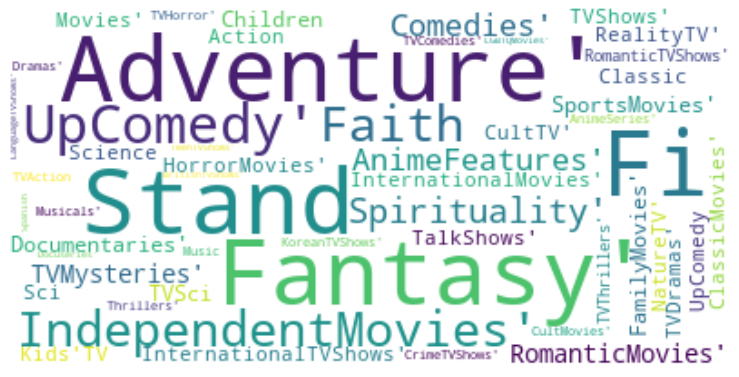

In [ ]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

text = list(set(gen))
plt.rcParams['figure.figsize'] = (13, 13)
wordcloud = WordCloud(max_font_size=50, max_words=100,background_color="white").generate(str(text))

plt.imshow(wordcloud,interpolation="bilinear")
plt.axis("off")
plt.show()

In [ ]:
gen

['Children&FamilyMovies',
 'Comedies',
 'Stand-UpComedy',
 "Kids'TV",
 "Kids'TV",
 'Comedies',
 'CrimeTVShows',
 'InternationalTVShows',
 'Spanish-LanguageTVShows',
 'InternationalMovies',
 'Sci-Fi&Fantasy',
 'Thrillers',
 'Stand-UpComedy',
 'Docuseries',
 'Science&NatureTV',
 'Action&Adventure',
 'Thrillers',
 'Stand-UpComedy',
 'Action&Adventure',
 'Dramas',
 'InternationalMovies',
 'Children&FamilyMovies',
 'Children&FamilyMovies',
 'Children&FamilyMovies',
 'Children&FamilyMovies',
 'Children&FamilyMovies',
 'Children&FamilyMovies',
 'Children&FamilyMovies',
 'CultMovies',
 'Dramas',
 'IndependentMovies',
 'Comedies',
 'IndependentMovies',
 'RomanticMovies',
 'Action&Adventure',
 'Comedies',
 'InternationalMovies',
 'Documentaries',
 'HorrorMovies',
 'Thrillers',
 'Dramas',
 'IndependentMovies',
 'Dramas',
 'IndependentMovies',
 'RomanticMovies',
 'InternationalTVShows',
 'RomanticTVShows',
 'TVComedies',
 'Documentaries',
 'Docuseries',
 'HorrorMovies',
 'InternationalMovies',
 'C

In [ ]:
new_df = netflix_df[['title','director','cast','listed_in','description']]
new_df.head()

new_df['director']=new_df['director'].fillna(' ')
new_df['director']=new_df['director'].astype('str')

new_df['cast']=new_df['cast'].fillna(' ')
new_df['cast']=new_df['cast'].astype('str')

new_df['bag_of_word']= ''
for index,row in new_df.iterrows():
    plot = row['description']
    r = Rake()
    r.extract_keywords_from_text(plot)
    keyword_score = r.get_word_degrees()
    g = ''.join(row['listed_in'].split(',')).lower()
    d = ''.join(row['director'].replace(' ','').split(',')).lower()
    a = ' '.join(row['cast'].replace(' ','').split(',')).lower()
    k = ' '.join(list(keyword_score.keys()))
    row['bag_of_word'] = g + ' ' + ' ' + d + ' ' + a + ' ' + k

mydf = new_df[['title','bag_of_word']]
mydf.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation:

,title,bag_of_word
0,Norm of the North: King Sized Adventure,children & family movies comedies richardfinn...
1,Jandino: Whatever it Takes,stand-up comedy jandinoasporaat fire rousing...
2,Transformers Prime,kids' tv petercullen sumaleemontano frankwel...
3,Transformers: Robots in Disguise,kids' tv willfriedle darrencriss constancezi...
4,#realityhigh,comedies fernandolebrija nestacooper katewals...


In [ ]:
vectorizer = TfidfVectorizer()

vectors = vectorizer.fit_transform(mydf['bag_of_word'])

feature_names = vectorizer.get_feature_names()

dense = vectors.todense()

denselist = dense.tolist()

tf_df_3 = pd.DataFrame(denselist, columns=feature_names)
tf_df_3